---
execute:
  cache: false
  eval: true
  echo: true
  warning: false
title: Hyperparameter Tuning with `spotpython` and `PyTorch` Lightning for the Diabetes Data Set Using a User Specified ResNet Model
jupyter: python3
---

In [1]:
#| label: 606_user-user-imports
#| echo: false
import os
from math import inf
import warnings
warnings.filterwarnings("ignore")

After importing the necessary libraries, the `fun_control` dictionary is set up via the `fun_control_init` function.
The `fun_control` dictionary contains

* `PREFIX`: a unique identifier for the experiment
* `fun_evals`: the number of function evaluations
* `max_time`: the maximum run time in minutes
* `data_set`: the data set. Here we use the `Diabetes` data set that is provided by `spotpython`.
* `core_model_name`: the class name of the neural network model. This neural network model is provided by `spotpython`.
* `hyperdict`: the hyperparameter dictionary. This dictionary is used to define the hyperparameters of the neural network model. It is also provided by `spotpython`.
* `_L_in`: the number of input features. Since the `Diabetes` data set has 10 features, `_L_in` is set to 10.
* `_L_out`: the number of output features. Since we want to predict a single value, `_L_out` is set to 1.

The `HyperLight` class is used to define the objective function `fun`.
It connects the `PyTorch` and the `spotpython` methods and is provided by `spotpython`.

To access the user specified ResNet model, the path to the user model must be added to the Python path:


In [2]:
#| label: 606_user-user-path_setup
import sys
sys.path.insert(0, './userModel')
import my_resnet
import my_hyper_dict

In the following code, we do not specify the ResNet model in the `fun_control` dictionary. It will be added in a second step as the user specified model.


In [3]:
#| label: 606_user-user-spotpython_setup

from spotpython.data.diabetes import Diabetes
from spotpython.hyperdict.light_hyper_dict import LightHyperDict
from spotpython.fun.hyperlight import HyperLight
from spotpython.utils.init import (fun_control_init, surrogate_control_init, design_control_init)
from spotpython.utils.eda import gen_design_table
from spotpython.spot import spot
from spotpython.utils.file import get_experiment_filename

PREFIX="606-user-resnet"

data_set = Diabetes()

fun_control = fun_control_init(
    PREFIX=PREFIX,
    fun_evals=inf,
    max_time=1,
    data_set = data_set,
    _L_in=10,
    _L_out=1)

fun = HyperLight().fun

Seed set to 123


Seed set to 123


In a second step, we can add the user specified ResNet model to the `fun_control` dictionary:


In [4]:
from spotpython.hyperparameters.values import add_core_model_to_fun_control
add_core_model_to_fun_control(fun_control=fun_control,
                              core_model=my_resnet.MyResNet,
                              hyper_dict=my_hyper_dict.MyHyperDict)

The method `set_hyperparameter` allows the user to modify default hyperparameter settings.
Here we modify some hyperparameters to keep the model small and to decrease the tuning time.


In [5]:
from spotpython.hyperparameters.values import set_hyperparameter
set_hyperparameter(fun_control, "optimizer", [ "Adadelta", "Adam", "Adamax"])
set_hyperparameter(fun_control, "l1", [3,4])
set_hyperparameter(fun_control, "epochs", [3,7])
set_hyperparameter(fun_control, "batch_size", [4,11])
set_hyperparameter(fun_control, "dropout_prob", [0.0, 0.025])
set_hyperparameter(fun_control, "patience", [2,3])
set_hyperparameter(fun_control, "lr_mult", [0.1, 20.0])

design_control = design_control_init(init_size=10)

print(gen_design_table(fun_control))

| name           | type   | default   |   lower |   upper | transform             |
|----------------|--------|-----------|---------|---------|-----------------------|
| l1             | int    | 3         |     3   |   4     | transform_power_2_int |
| epochs         | int    | 4         |     3   |   7     | transform_power_2_int |
| batch_size     | int    | 4         |     4   |  11     | transform_power_2_int |
| act_fn         | factor | ReLU      |     0   |   5     | None                  |
| optimizer      | factor | SGD       |     0   |   2     | None                  |
| dropout_prob   | float  | 0.01      |     0   |   0.025 | None                  |
| lr_mult        | float  | 1.0       |     0.1 |  20     | None                  |
| patience       | int    | 2         |     2   |   3     | transform_power_2_int |
| initialization | factor | Default   |     0   |   4     | None                  |


Finally, a `Spot` object is created.
Calling the method `run()` starts the hyperparameter tuning process.


In [6]:
#| label: 606_user-user-run
spot_tuner = spot.Spot(fun=fun,fun_control=fun_control, design_control=design_control)
res = spot_tuner.run()

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


Milestones: [16, 32, 48]



  | Name   | Type       | Params | Mode  | In sizes  | Out sizes
----------------------------------------------------------------------
0 | layers | Sequential | 637    | train | [128, 10] | [128, 1] 
----------------------------------------------------------------------
637       Trainable params
0         Non-trainable params
637       Total params
0.003     Total estimated model params size (MB)
63        Modules in train mode
0         Modules in eval mode


GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | Mode  | In sizes  | Out sizes
----------------------------------------------------------------------
0 | layers | Sequential | 1.8 K  | train | [128, 10] | [128, 1] 
----------------------------------------------------------------------
1.8 K     Trainable params
0         Non-trainable params
1.8 K     Total params
0.007     Total estimated model params size (MB)
101       Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 23449.109375, 'hp_metric': 23449.109375}
Milestones: [2, 4, 6]


`Trainer.fit` stopped: `max_epochs=8` reached.


GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | Mode  | In sizes  | Out sizes
----------------------------------------------------------------------
0 | layers | Sequential | 1.8 K  | train | [512, 10] | [512, 1] 
----------------------------------------------------------------------
1.8 K     Trainable params
0         Non-trainable params
1.8 K     Total params
0.007     Total estimated model params size (MB)
101       Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 24580.740234375, 'hp_metric': 24580.740234375}
Milestones: [16, 32, 48]


GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 1.8 K  | train | [16, 10] | [16, 1]  
---------------------------------------------------------------------
1.8 K     Trainable params
0         Non-trainable params
1.8 K     Total params
0.007     Total estimated model params size (MB)
101       Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 23744.66796875, 'hp_metric': 23744.66796875}
Milestones: [2, 4, 6]


`Trainer.fit` stopped: `max_epochs=8` reached.


GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | Mode  | In sizes   | Out sizes
-----------------------------------------------------------------------
0 | layers | Sequential | 1.8 K  | train | [1024, 10] | [1024, 1]
-----------------------------------------------------------------------
1.8 K     Trainable params
0         Non-trainable params
1.8 K     Total params
0.007     Total estimated model params size (MB)
101       Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 23675.974609375, 'hp_metric': 23675.974609375}
Milestones: [32, 64, 96]


GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | Mode  | In sizes   | Out sizes
-----------------------------------------------------------------------
0 | layers | Sequential | 637    | train | [2048, 10] | [2048, 1]
-----------------------------------------------------------------------
637       Trainable params
0         Non-trainable params
637       Total params
0.003     Total estimated model params size (MB)
63        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 24016.11328125, 'hp_metric': 24016.11328125}
Milestones: [32, 64, 96]


GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | Mode  | In sizes  | Out sizes
----------------------------------------------------------------------
0 | layers | Sequential | 637    | train | [256, 10] | [256, 1] 
----------------------------------------------------------------------
637       Trainable params
0         Non-trainable params
637       Total params
0.003     Total estimated model params size (MB)
63        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 6686.21240234375, 'hp_metric': 6686.21240234375}
Milestones: [4, 8, 12]


GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | Mode  | In sizes  | Out sizes
----------------------------------------------------------------------
0 | layers | Sequential | 637    | train | [512, 10] | [512, 1] 
----------------------------------------------------------------------
637       Trainable params
0         Non-trainable params
637       Total params
0.003     Total estimated model params size (MB)
63        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 24109.787109375, 'hp_metric': 24109.787109375}
Milestones: [4, 8, 12]


GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 637    | train | [32, 10] | [32, 1]  
---------------------------------------------------------------------
637       Trainable params
0         Non-trainable params
637       Total params
0.003     Total estimated model params size (MB)
63        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 23714.3203125, 'hp_metric': 23714.3203125}
Milestones: [8, 16, 24]


GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 1.8 K  | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
1.8 K     Trainable params
0         Non-trainable params
1.8 K     Total params
0.007     Total estimated model params size (MB)
101       Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 21453.193359375, 'hp_metric': 21453.193359375}
Milestones: [8, 16, 24]


`Trainer.fit` stopped: `max_epochs=32` reached.


train_model result: {'val_loss': 23739.24609375, 'hp_metric': 23739.24609375}


GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | Mode  | In sizes   | Out sizes
-----------------------------------------------------------------------
0 | layers | Sequential | 637    | train | [2048, 10] | [2048, 1]
-----------------------------------------------------------------------
637       Trainable params
0         Non-trainable params
637       Total params
0.003     Total estimated model params size (MB)
63        Modules in train mode
0         Modules in eval mode


Milestones: [32, 64, 96]


train_model result: {'val_loss': 5624.23486328125, 'hp_metric': 5624.23486328125}
spotpython tuning: 5624.23486328125 [#---------] 5.99% 


GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | Mode  | In sizes   | Out sizes
-----------------------------------------------------------------------
0 | layers | Sequential | 637    | train | [2048, 10] | [2048, 1]
-----------------------------------------------------------------------
637       Trainable params
0         Non-trainable params
637       Total params
0.003     Total estimated model params size (MB)
63        Modules in train mode
0         Modules in eval mode


Milestones: [32, 64, 96]


train_model result: {'val_loss': 3792.017578125, 'hp_metric': 3792.017578125}


spotpython tuning: 3792.017578125 [#---------] 13.40% 


GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | Mode  | In sizes   | Out sizes
-----------------------------------------------------------------------
0 | layers | Sequential | 637    | train | [2048, 10] | [2048, 1]
-----------------------------------------------------------------------
637       Trainable params
0         Non-trainable params
637       Total params
0.003     Total estimated model params size (MB)
63        Modules in train mode
0         Modules in eval mode


Milestones: [32, 64, 96]


`Trainer.fit` stopped: `max_epochs=128` reached.


train_model result: {'val_loss': 6528.82763671875, 'hp_metric': 6528.82763671875}


spotpython tuning: 3792.017578125 [###-------] 34.49% 


GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | Mode  | In sizes   | Out sizes
-----------------------------------------------------------------------
0 | layers | Sequential | 637    | train | [2048, 10] | [2048, 1]
-----------------------------------------------------------------------
637       Trainable params
0         Non-trainable params
637       Total params
0.003     Total estimated model params size (MB)
63        Modules in train mode
0         Modules in eval mode


Milestones: [32, 64, 96]


train_model result: {'val_loss': 4984.78466796875, 'hp_metric': 4984.78466796875}


spotpython tuning: 3792.017578125 [####------] 42.06% 


GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | Mode  | In sizes   | Out sizes
-----------------------------------------------------------------------
0 | layers | Sequential | 637    | train | [2048, 10] | [2048, 1]
-----------------------------------------------------------------------
637       Trainable params
0         Non-trainable params
637       Total params
0.003     Total estimated model params size (MB)
63        Modules in train mode
0         Modules in eval mode


Milestones: [32, 64, 96]


train_model result: {'val_loss': 5016.91162109375, 'hp_metric': 5016.91162109375}


spotpython tuning: 3792.017578125 [#####-----] 51.21% 


GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 637    | train | [16, 10] | [16, 1]  
---------------------------------------------------------------------
637       Trainable params
0         Non-trainable params
637       Total params
0.003     Total estimated model params size (MB)
63        Modules in train mode
0         Modules in eval mode


Milestones: [32, 64, 96]


train_model result: {'val_loss': 23554.8984375, 'hp_metric': 23554.8984375}


spotpython tuning: 3792.017578125 [######----] 60.17% 


GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | Mode  | In sizes   | Out sizes
-----------------------------------------------------------------------
0 | layers | Sequential | 637    | train | [2048, 10] | [2048, 1]
-----------------------------------------------------------------------
637       Trainable params
0         Non-trainable params
637       Total params
0.003     Total estimated model params size (MB)
63        Modules in train mode
0         Modules in eval mode


Milestones: [2, 4, 6]


`Trainer.fit` stopped: `max_epochs=8` reached.


train_model result: {'val_loss': 21770.8203125, 'hp_metric': 21770.8203125}


spotpython tuning: 3792.017578125 [######----] 63.72% 


GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | Mode  | In sizes   | Out sizes
-----------------------------------------------------------------------
0 | layers | Sequential | 637    | train | [2048, 10] | [2048, 1]
-----------------------------------------------------------------------
637       Trainable params
0         Non-trainable params
637       Total params
0.003     Total estimated model params size (MB)
63        Modules in train mode
0         Modules in eval mode


Milestones: [32, 64, 96]


train_model result: {'val_loss': 22465.623046875, 'hp_metric': 22465.623046875}


spotpython tuning: 3792.017578125 [########--] 83.94% 


GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 637    | train | [16, 10] | [16, 1]  
---------------------------------------------------------------------
637       Trainable params
0         Non-trainable params
637       Total params
0.003     Total estimated model params size (MB)
63        Modules in train mode
0         Modules in eval mode


Milestones: [2, 4, 6]


`Trainer.fit` stopped: `max_epochs=8` reached.


train_model result: {'val_loss': 13155.591796875, 'hp_metric': 13155.591796875}


spotpython tuning: 3792.017578125 [#########-] 93.32% 


GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 637    | train | [16, 10] | [16, 1]  
---------------------------------------------------------------------
637       Trainable params
0         Non-trainable params
637       Total params
0.003     Total estimated model params size (MB)
63        Modules in train mode
0         Modules in eval mode


Milestones: [32, 64, 96]


train_model result: {'val_loss': 4112.88427734375, 'hp_metric': 4112.88427734375}


spotpython tuning: 3792.017578125 [##########] 100.00% Done...



## Looking at the Results

### Tuning Progress

After the hyperparameter tuning run is finished, the progress of the hyperparameter tuning can be visualized with `spotpython`'s method `plot_progress`. The black points represent the performace values (score or metric) of  hyperparameter configurations from the initial design, whereas the red points represents the  hyperparameter configurations found by the surrogate model based optimization.


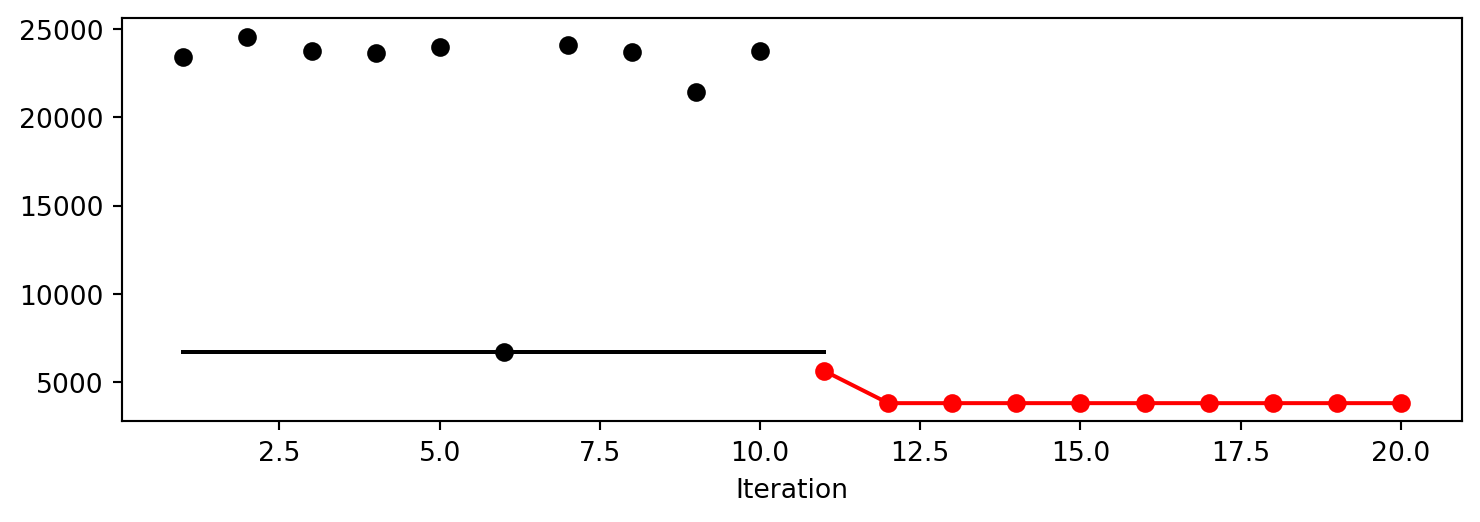

In [7]:
spot_tuner.plot_progress()

### Tuned Hyperparameters and Their Importance

Results can be printed in tabular form.


In [8]:
from spotpython.utils.eda import gen_design_table
print(gen_design_table(fun_control=fun_control, spot=spot_tuner))

| name           | type   | default   |   lower |   upper | tuned                | transform             |   importance | stars   |
|----------------|--------|-----------|---------|---------|----------------------|-----------------------|--------------|---------|
| l1             | int    | 3         |     3.0 |     4.0 | 3.0                  | transform_power_2_int |         0.20 | .       |
| epochs         | int    | 4         |     3.0 |     7.0 | 7.0                  | transform_power_2_int |         0.37 | .       |
| batch_size     | int    | 4         |     4.0 |    11.0 | 11.0                 | transform_power_2_int |         0.22 | .       |
| act_fn         | factor | ReLU      |     0.0 |     5.0 | ReLU                 | None                  |         0.35 | .       |
| optimizer      | factor | SGD       |     0.0 |     2.0 | Adadelta             | None                  |         0.29 | .       |
| dropout_prob   | float  | 0.01      |     0.0 |   0.025 | 0.01553896577008

A histogram can be used to visualize the most important hyperparameters.


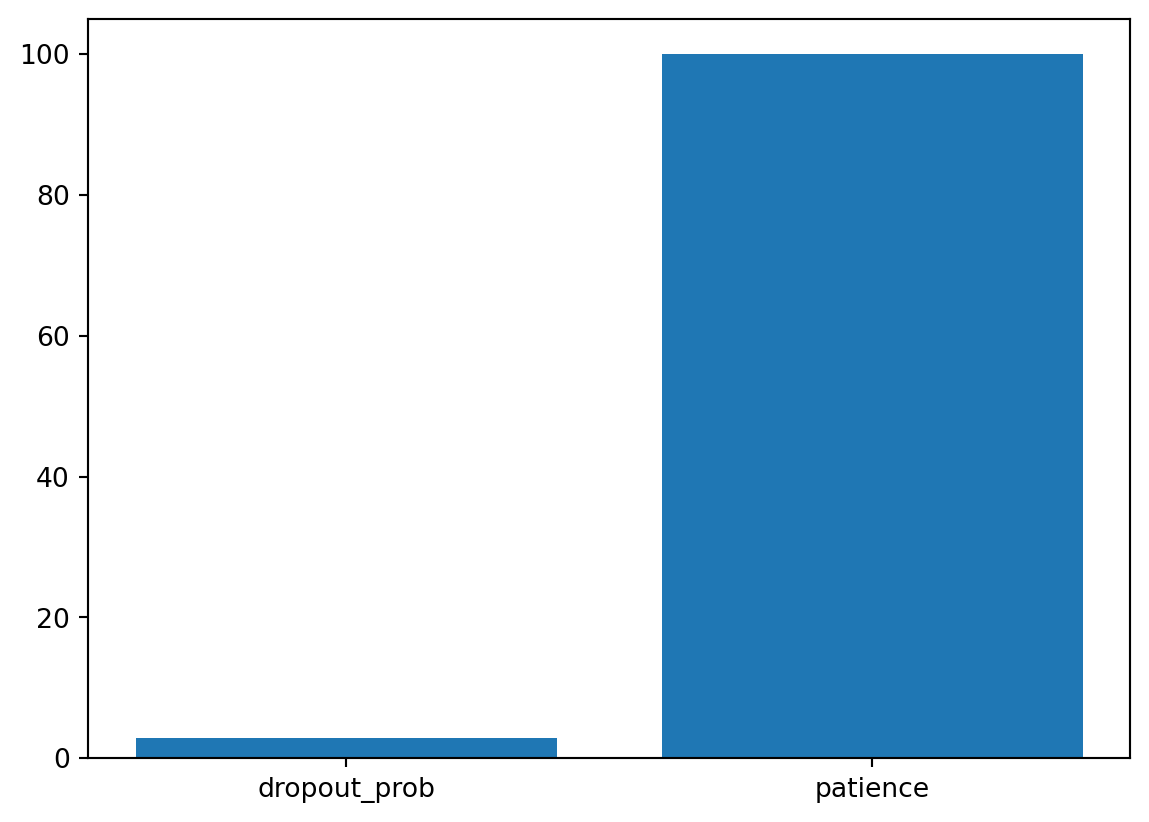

In [9]:
spot_tuner.plot_importance(threshold=1.0)

l1:  0.20022018647632916
epochs:  0.36770284649306495
batch_size:  0.22043962999845218
act_fn:  0.35269732441450835
optimizer:  0.2932560330532338
dropout_prob:  2.840683257228657
lr_mult:  0.23328412651500768
patience:  100.0
initialization:  0.2610687626218617


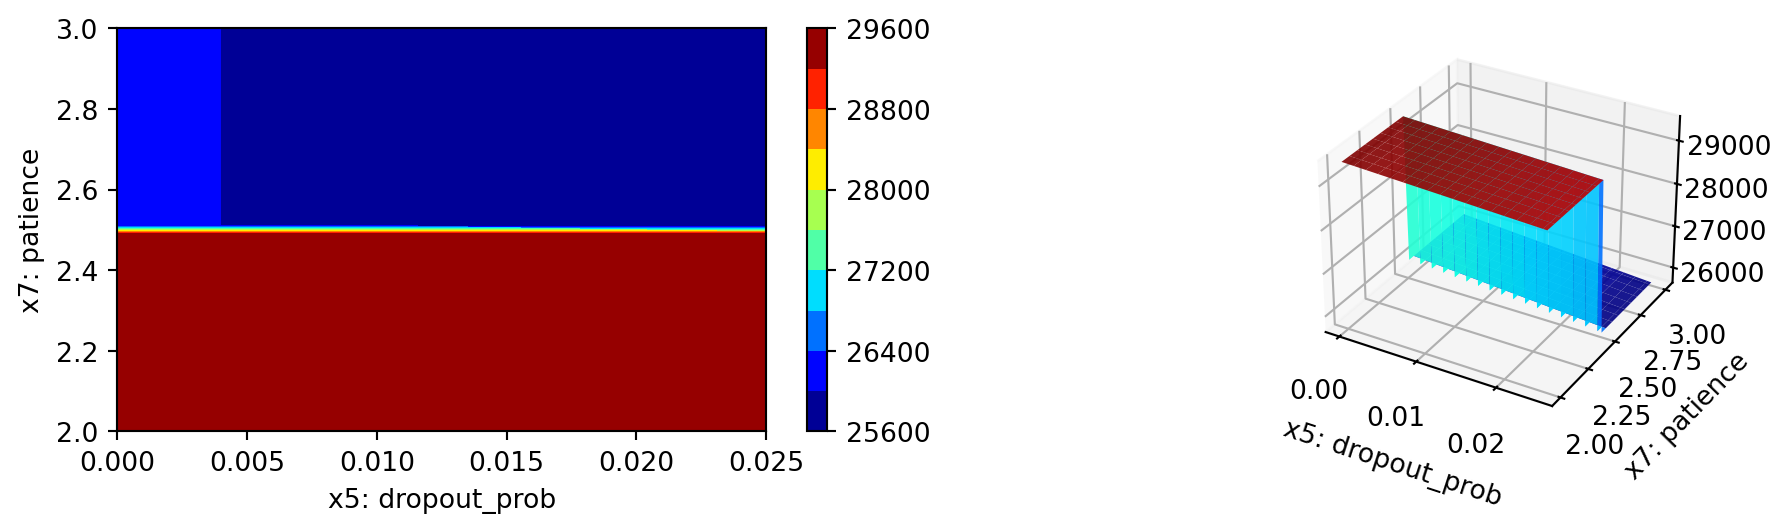

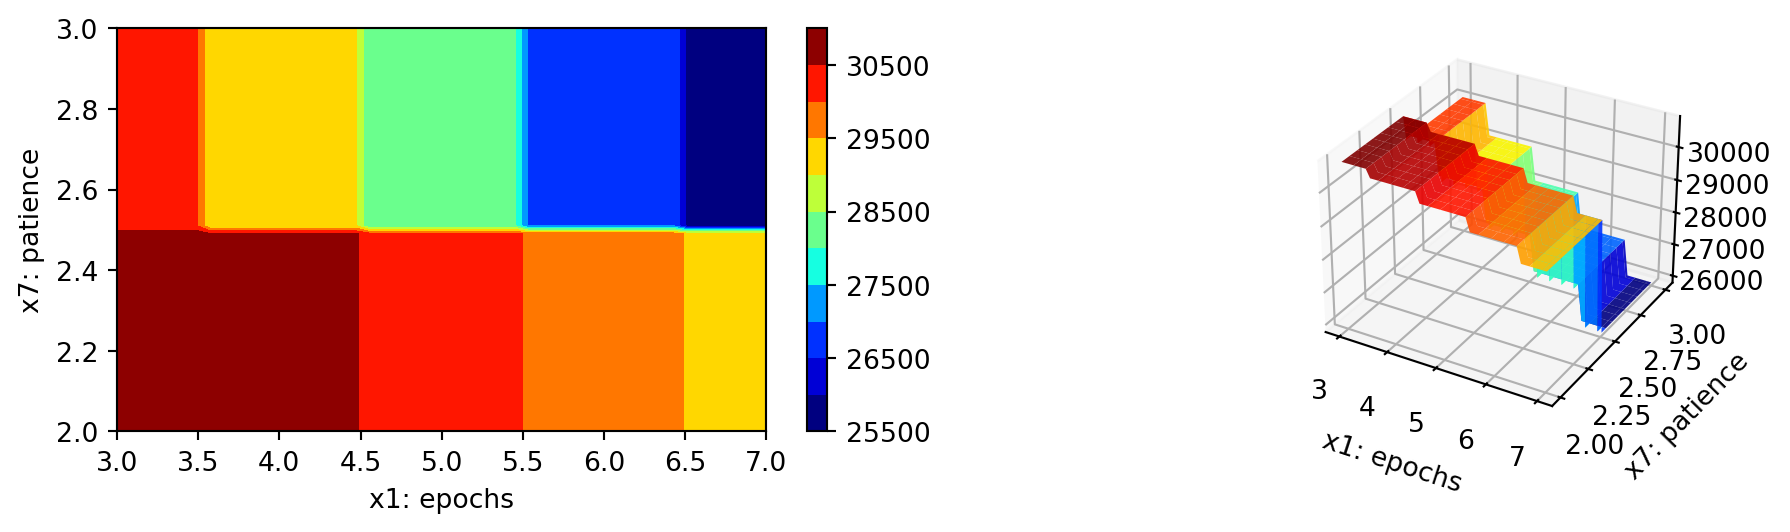

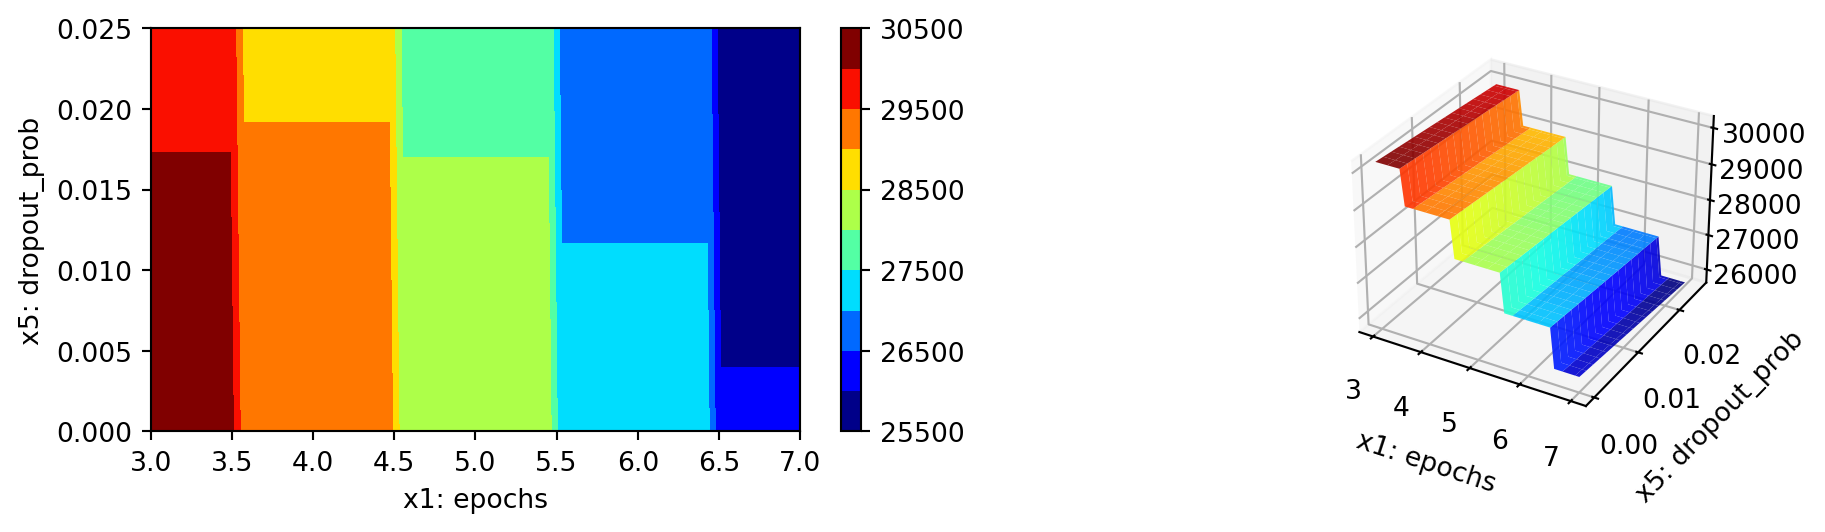

In [10]:
spot_tuner.plot_important_hyperparameter_contour(max_imp=3)

### Get the Tuned Architecture {#sec-get-spot-results-605}


In [11]:
import pprint
from spotpython.hyperparameters.values import get_tuned_architecture
config = get_tuned_architecture(spot_tuner, fun_control)
pprint.pprint(config)

{'act_fn': ReLU(),
 'batch_size': 2048,
 'dropout_prob': 0.015538965770081114,
 'epochs': 128,
 'initialization': 'kaiming_uniform',
 'l1': 8,
 'lr_mult': 20.0,
 'optimizer': 'Adadelta',
 'patience': 8}


## Details of the User-Specified ResNet Model

The specification of a user model requires three files:

* `my_resnet.py`: the Python file containing the user specified ResNet model
* `my_hyperdict.py`: the Python file for loading the hyperparameter dictionary `my_hyperdict.json` for the user specified ResNet model
* `my_hyperdict.json`: the JSON file containing the hyperparameter dictionary for the user specified ResNet model



### `my_resnet.py`

```python
import lightning as L
import torch
from torch import nn
from spotpython.hyperparameters.optimizer import optimizer_handler
import torchmetrics.functional.regression
import torch.optim as optim

class ResidualBlock(nn.Module):
    def __init__(self, input_dim, output_dim, act_fn, dropout_prob):
        super(ResidualBlock, self).__init__()
        self.fc1 = nn.Linear(input_dim, output_dim)
        self.bn1 = nn.BatchNorm1d(output_dim)
        self.ln1 = nn.LayerNorm(output_dim)  
        self.fc2 = nn.Linear(output_dim, output_dim)
        self.bn2 = nn.BatchNorm1d(output_dim)
        self.ln2 = nn.LayerNorm(output_dim)
        self.act_fn = act_fn
        self.dropout = nn.Dropout(dropout_prob)
        self.shortcut = nn.Sequential()

        if input_dim != output_dim:
            self.shortcut = nn.Sequential(
                nn.Linear(input_dim, output_dim),
                nn.BatchNorm1d(output_dim)
            )
    
    def forward(self, x):
        identity = self.shortcut(x)
        
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.ln1(out)
        out = self.act_fn(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.bn2(out)
        out = self.ln2(out)
        out += identity  # Residual connection
        out = self.act_fn(out)
        return out

class MyResNet(L.LightningModule):
    def __init__(
        self,
        l1: int,
        epochs: int,
        batch_size: int,
        initialization: str,
        act_fn: nn.Module,
        optimizer: str,
        dropout_prob: float,
        lr_mult: float,
        patience: int,
        _L_in: int,
        _L_out: int,
        _torchmetric: str,
    ):
        super().__init__()
        self._L_in = _L_in
        self._L_out = _L_out
        if _torchmetric is None:
            _torchmetric = "mean_squared_error"
        self._torchmetric = _torchmetric
        self.metric = getattr(torchmetrics.functional.regression, _torchmetric)
        self.save_hyperparameters(ignore=["_L_in", "_L_out", "_torchmetric"])
        self.example_input_array = torch.zeros((batch_size, self._L_in))
        
        if self.hparams.l1 < 4:
            raise ValueError("l1 must be at least 4")
        
        # Get hidden sizes
        hidden_sizes = self._get_hidden_sizes()
        layer_sizes = [self._L_in] + hidden_sizes

        # Construct the layers with Residual Blocks and Linear Layer at the end
        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(
                ResidualBlock(
                    layer_sizes[i], 
                    layer_sizes[i + 1], 
                    self.hparams.act_fn, 
                    self.hparams.dropout_prob
                )
            )
        layers.append(nn.Linear(layer_sizes[-1], self._L_out))
        
        self.layers = nn.Sequential(*layers)

        # Initialization (Xavier, Kaiming, or Default)
        self.apply(self._init_weights)

    def _init_weights(self, module):        
        if isinstance(module, nn.Linear):
            if self.hparams.initialization == "xavier_uniform":
                nn.init.xavier_uniform_(module.weight)
            elif self.hparams.initialization == "xavier_normal":
                nn.init.xavier_normal_(module.weight)
            elif self.hparams.initialization == "kaiming_uniform":
                nn.init.kaiming_uniform_(module.weight)
            elif self.hparams.initialization == "kaiming_normal":
                nn.init.kaiming_normal_(module.weight)
            else: # "Default"
                nn.init.uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
    
    def _generate_div2_list(self, n, n_min) -> list:
        result = []
        current = n
        repeats = 1
        max_repeats = 4
        while current >= n_min:
            result.extend([current] * min(repeats, max_repeats))
            current = current // 2
            repeats = repeats + 1
        return result

    def _get_hidden_sizes(self):
        n_low = max(2, int(self._L_in / 4))  # Ensure minimum reasonable size
        n_high = max(self.hparams.l1, 2 * n_low)
        hidden_sizes = self._generate_div2_list(n_high, n_low)
        return hidden_sizes

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.layers(x)
        return x

    def _calculate_loss(self, batch):
        x, y = batch
        y = y.view(len(y), 1)
        y_hat = self(x)
        loss = self.metric(y_hat, y)
        return loss

    def training_step(self, batch: tuple) -> torch.Tensor:
        val_loss = self._calculate_loss(batch)
        return val_loss

    def validation_step(self, batch: tuple, batch_idx: int, prog_bar: bool = False) -> torch.Tensor:
        val_loss = self._calculate_loss(batch)
        self.log("val_loss", val_loss, prog_bar=prog_bar)
        self.log("hp_metric", val_loss, prog_bar=prog_bar)
        return val_loss

    def test_step(self, batch: tuple, batch_idx: int, prog_bar: bool = False) -> torch.Tensor:
        val_loss = self._calculate_loss(batch)
        self.log("val_loss", val_loss, prog_bar=prog_bar)
        self.log("hp_metric", val_loss, prog_bar=prog_bar)
        return val_loss

    def predict_step(self, batch: tuple, batch_idx: int, prog_bar: bool = False) -> torch.Tensor:
        x, y = batch
        yhat = self(x)
        y = y.view(len(y), 1)
        yhat = yhat.view(len(yhat), 1)
        return (x, y, yhat)

    def configure_optimizers(self):
        optimizer = optimizer_handler(
            optimizer_name=self.hparams.optimizer,
            params=self.parameters(),
            lr_mult=self.hparams.lr_mult
        )

        # Dynamic creation of milestones based on the number of epochs.
        num_milestones = 3  # Number of milestones to divide the epochs
        milestones = [int(self.hparams.epochs / (num_milestones + 1) * (i + 1)) for i in range(num_milestones)]

        # Print milestones for debug purposes
        print(f"Milestones: {milestones}")

        # Create MultiStepLR scheduler with dynamic milestones and learning rate multiplier.
        scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer, 
            milestones=milestones, 
            gamma=0.1  # Decay factor
        )

        # Learning rate scheduler configuration
        lr_scheduler_config = {
            "scheduler": scheduler,
            "interval": "epoch",  # Adjust learning rate per epoch
            "frequency": 1,      # Apply the scheduler at every epoch
        }
        
        return {"optimizer": optimizer, "lr_scheduler": lr_scheduler_config}
```

### `my_hyperdict.py`

```python
import json
from spotpython.data import base
import pathlib


class MyHyperDict(base.FileConfig):
    """User specified hyperparameter dictionary.

    This class extends the FileConfig class to provide a dictionary for storing hyperparameters.

    Attributes:
        filename (str):
            The name of the file where the hyperparameters are stored.
    """

    def __init__(
        self,
        filename: str = "my_hyper_dict.json",
        directory: None = None,
    ) -> None:
        super().__init__(filename=filename, directory=directory)
        self.filename = filename
        self.directory = directory
        self.hyper_dict = self.load()

    @property
    def path(self):
        if self.directory:
            return pathlib.Path(self.directory).joinpath(self.filename)
        return pathlib.Path(__file__).parent.joinpath(self.filename)

    def load(self) -> dict:
        """Load the hyperparameters from the file.

        Returns:
            dict: A dictionary containing the hyperparameters.

        Examples:
            # Assume the user specified file `my_hyper_dict.json` is in the `./hyperdict/` directory.
            >>> user_lhd = MyHyperDict(filename='my_hyper_dict.json', directory='./hyperdict/')
        """
        with open(self.path, "r") as f:
            d = json.load(f)
        return d
```

### `my_hyperdict.json`

```python
 "MyResNet": {
        "l1": {
            "type": "int",
            "default": 3,
            "transform": "transform_power_2_int",
            "lower": 3,
            "upper": 10
        },
        "epochs": {
            "type": "int",
            "default": 4,
            "transform": "transform_power_2_int",
            "lower": 4,
            "upper": 9
        },
        "batch_size": {
            "type": "int",
            "default": 4,
            "transform": "transform_power_2_int",
            "lower": 1,
            "upper": 6
        },
        "act_fn": {
            "levels": [
                "Sigmoid",
                "Tanh",
                "ReLU",
                "LeakyReLU",
                "ELU",
                "Swish"
            ],
            "type": "factor",
            "default": "ReLU",
            "transform": "None",
            "class_name": "spotpython.torch.activation",
            "core_model_parameter_type": "instance()",
            "lower": 0,
            "upper": 5
        },
        "optimizer": {
            "levels": [
                "Adadelta",
                "Adagrad",
                "Adam",
                "AdamW",
                "SparseAdam",
                "Adamax",
                "ASGD",
                "NAdam",
                "RAdam",
                "RMSprop",
                "Rprop",
                "SGD"
            ],
            "type": "factor",
            "default": "SGD",
            "transform": "None",
            "class_name": "torch.optim",
            "core_model_parameter_type": "str",
            "lower": 0,
            "upper": 11
        },
        "dropout_prob": {
            "type": "float",
            "default": 0.01,
            "transform": "None",
            "lower": 0.0,
            "upper": 0.25
        },
        "lr_mult": {
            "type": "float",
            "default": 1.0,
            "transform": "None",
            "lower": 0.1,
            "upper": 10.0
        },
        "patience": {
            "type": "int",
            "default": 2,
            "transform": "transform_power_2_int",
            "lower": 2,
            "upper": 6
        },
        "initialization": {
            "levels": [
                "Default",
                "kaiming_uniform",
                "kaiming_normal",
                "xavier_uniform",
                "xavier_normal"
            ],
            "type": "factor",
            "default": "Default",
            "transform": "None",
            "core_model_parameter_type": "str",
            "lower": 0,
            "upper": 4
        }
    }
```

## Summary

This section presented an introduction to the basic setup of hyperparameter tuning with `spotpython` and `PyTorch` Lightning using a ResNet model for the Diabetes data set.
